[Retrain 1/30] loss=0.6637
[Retrain 2/30] loss=0.6081
[Retrain 3/30] loss=0.5596
[Retrain 4/30] loss=0.5246
[Retrain 5/30] loss=0.4956
[Retrain 6/30] loss=0.4637
[Retrain 7/30] loss=0.4450
[Retrain 8/30] loss=0.4207
[Retrain 9/30] loss=0.3885
[Retrain 10/30] loss=0.3772
[Retrain 11/30] loss=0.3552
[Retrain 12/30] loss=0.3320
[Retrain 13/30] loss=0.3104
[Retrain 14/30] loss=0.2985
[Retrain 15/30] loss=0.2820
[Retrain 16/30] loss=0.2646
[Retrain 17/30] loss=0.2502
[Retrain 18/30] loss=0.2387
[Retrain 19/30] loss=0.2234
[Retrain 20/30] loss=0.2168
[Retrain 21/30] loss=0.1982
[Retrain 22/30] loss=0.1857
[Retrain 23/30] loss=0.1748
[Retrain 24/30] loss=0.1652
[Retrain 25/30] loss=0.1558
[Retrain 26/30] loss=0.1508
[Retrain 27/30] loss=0.1352
[Retrain 28/30] loss=0.1353
[Retrain 29/30] loss=0.1269
[Retrain 30/30] loss=0.1184
[MLP VALID ROC] Optimal threshold = 0.651
Full Test AUC: 0.2714
Test Acc @ thr=0.651: 0.3200
Confusion Matrix:
 [[ 23 114]
 [ 73  65]]
Classification Report:
           

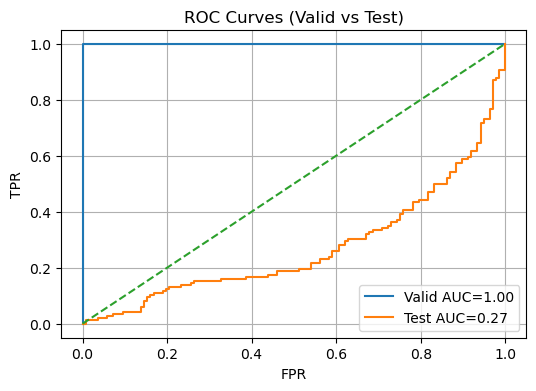

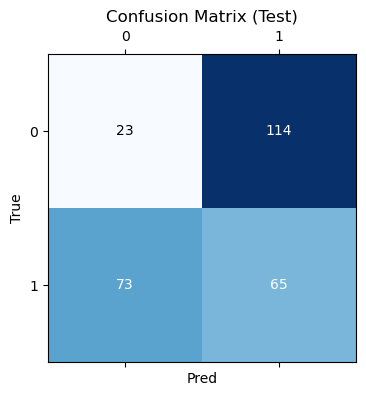

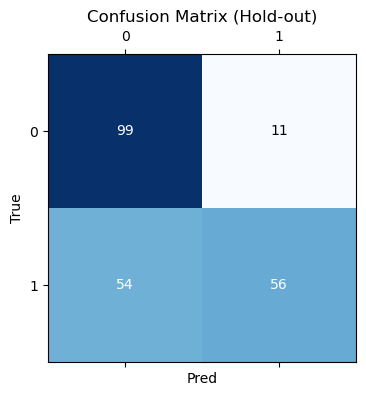

In [ ]:
# Jupyter Notebook용: Test 일부로 재학습(fine-tune) 및 이미지 저장까지 포함한 통합 스크립트
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

# ────────────────────────────────────────────────────────
# 0. 설정
DATA_ROOT       = Path("embbeding_data")
AGG_METHOD      = "max" # 해당 파라미터를 통해 stgcn의 차원 축소 방법을 지정
# "mean" / "max" / "flatten" 중 하나 선택
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 30
EARLY_STOP      = 5       # fine-tune 조기종료 patience
TEST_FRACTION   = 0.2     # 테스트의 20%를 fine-tune에 사용
SAVE_DIR        = Path("fusion_images")
SAVE_DIR.mkdir(exist_ok=True)
# ────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────
# 1. Embedding & Label 로드 함수
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

# TS / ST train-valid-test 전부 로드
X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")
X_ts_te, y_te = load_split("test",    "timesformer")
X_st_te, _    = load_split("test",    "stgcnpp")

# ST 차원 평균 축소
X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

# ────────────────────────────────────────────────────────
# 2. Scaler 학습 (Train+Valid 합쳐서)
X_train = np.concatenate([X_ts_tr, X_st_tr], axis=1)   # (348, feat_dim)
X_valid = np.concatenate([X_ts_va, X_st_va], axis=1)   # ( 88, feat_dim)
scaler  = StandardScaler().fit(
    np.vstack([X_train, X_valid])                     # (436, feat_dim)
)

# 데이터 스케일링
X_tr_scaled  = scaler.transform(X_train).astype(np.float32)
X_va_scaled  = scaler.transform(X_valid).astype(np.float32)
X_te_scaled  = scaler.transform(
    np.concatenate([X_ts_te, X_st_te], axis=1)
).astype(np.float32)

# ────────────────────────────────────────────────────────
# 3. Train+Valid 전체로 Head MLP 재학습
X_trva = np.vstack([X_tr_scaled, X_va_scaled])  # (436, feat_dim)
y_trva = np.concatenate([y_tr, y_va], axis=0)   # (436,)

class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.net(x)

model = HeadMLP(X_trva.shape[1]).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit  = nn.CrossEntropyLoss()

ds_trva = TensorDataset(torch.from_numpy(X_trva), torch.from_numpy(y_trva))
dl_trva = DataLoader(ds_trva, batch_size=BATCH_SIZE, shuffle=True)

best_loss, patience = float('inf'), 0
for epoch in range(1, RETRAIN_EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in dl_trva:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out = model(xb)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        running += loss.item() * yb.size(0)
    avg = running / len(ds_trva)
    print(f"[Retrain {epoch}/{RETRAIN_EPOCHS}] loss={avg:.4f}")
    if avg < best_loss:
        best_loss, patience = avg, 0
        best_state = model.state_dict()
    else:
        patience += 1
        if patience >= EARLY_STOP:
            print("Early stopping retrain")
            break

model.load_state_dict(best_state)

# ────────────────────────────────────────────────────────
# 4. VALID에서 MLP 기준으로 optimal threshold 계산
model.eval()
with torch.no_grad():
    va_tensor    = torch.from_numpy(X_va_scaled).to(DEVICE)
    va_out       = model(va_tensor)
    probs_va_mlp = torch.softmax(va_out, 1)[:, 1].cpu().numpy()

fpr_va, tpr_va, ths_va = roc_curve(y_va, probs_va_mlp)
opt_thr_va = ths_va[np.argmax(tpr_va - fpr_va)]
print(f"[MLP VALID ROC] Optimal threshold = {opt_thr_va:.3f}")

# ────────────────────────────────────────────────────────
# 5. Full Test 평가 (MLP VALID threshold 적용)
model.eval()
with torch.no_grad():
    te_tensor = torch.from_numpy(X_te_scaled).to(DEVICE)
    te_out    = model(te_tensor)
    probs_te  = torch.softmax(te_out,1)[:,1].cpu().numpy()

fpr_te, tpr_te, _ = roc_curve(y_te, probs_te)
auc_te = auc(fpr_te, tpr_te)
print(f"Full Test AUC: {auc_te:.4f}")

preds_te = (probs_te > opt_thr_va).astype(int)
acc_te   = accuracy_score(y_te, preds_te)
cm_te    = confusion_matrix(y_te, preds_te)
print(f"Test Acc @ thr={opt_thr_va:.3f}: {acc_te:.4f}")
print("Confusion Matrix:\n", cm_te)
print("Classification Report:\n",
      classification_report(y_te, preds_te, digits=4))

# ────────────────────────────────────────────────────────
# 6. Hold-out fine-tune 및 평가
X_te_ft, X_te_hold, y_te_ft, y_te_hold = train_test_split(
    X_te_scaled, y_te, test_size=1-TEST_FRACTION,
    stratify=y_te, random_state=42
)
X_ft_tr = np.vstack([X_trva, X_te_ft])
y_ft_tr = np.concatenate([y_trva, y_te_ft], axis=0)

model_ft = HeadMLP(X_ft_tr.shape[1]).to(DEVICE)
opt_ft   = torch.optim.AdamW(model_ft.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

best_loss, patience = float('inf'), 0
ds_ft = TensorDataset(torch.from_numpy(X_ft_tr), torch.from_numpy(y_ft_tr))
dl_ft = DataLoader(ds_ft, batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(1, RETRAIN_EPOCHS+1):
    model_ft.train()
    running = 0.0
    for xb, yb in dl_ft:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_ft.zero_grad()
        out = model_ft(xb)
        loss = crit(out, yb)
        loss.backward(); opt_ft.step()
        running += loss.item() * yb.size(0)
    avg = running / len(ds_ft)
    if avg < best_loss:
        best_loss, patience = avg, 0
        best_state_ft = model_ft.state_dict()
    else:
        patience += 1
        if patience >= EARLY_STOP: break

model_ft.load_state_dict(best_state_ft)

model_ft.eval()
with torch.no_grad():
    hold_tensor = torch.from_numpy(X_te_hold).to(DEVICE)
    hold_out    = model_ft(hold_tensor)
    probs_hold  = torch.softmax(hold_out,1)[:,1].cpu().numpy()

preds_hold = (probs_hold > opt_thr_va).astype(int)
acc_h = accuracy_score(y_te_hold, preds_hold)
auc_h = auc(*roc_curve(y_te_hold, probs_hold)[:2])
cm_h  = confusion_matrix(y_te_hold, preds_hold)

print(f"Hold-out Acc @ thr={opt_thr_va:.3f}: {acc_h:.4f}, AUC={auc_h:.4f}")
print("Hold-out CM:\n", cm_h)
print("Hold-out Report:\n", classification_report(y_te_hold, preds_hold, digits=4))

# ────────────────────────────────────────────────────────
# 7. 이미지 저장 (ROC & Confusion Matrix)
plt.figure(figsize=(6,4))
plt.plot(fpr_va, tpr_va, label=f"Valid AUC={auc(fpr_va,tpr_va):.2f}")
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Valid vs Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_val_test.png")
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
cax = ax.matshow(cm_te, cmap="Blues")
for (i,j),v in np.ndenumerate(cm_te):
    ax.text(j,i,str(v),ha='center',va='center',
            color='white' if v>cm_te.max()/2 else 'black')
ax.set_xlabel("Pred"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Test)")
fig.savefig(SAVE_DIR/"confusion_test.png")
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(4,4))
cax = ax.matshow(cm_h, cmap="Blues")
for (i,j),v in np.ndenumerate(cm_h):
    ax.text(j,i,str(v),ha='center',va='center',
            color='white' if v>cm_h.max()/2 else 'black')
ax.set_xlabel("Pred"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Hold-out)")
fig.savefig(SAVE_DIR/"confusion_holdout.png")
plt.show()
plt.close(fig)


# PCA 시각화

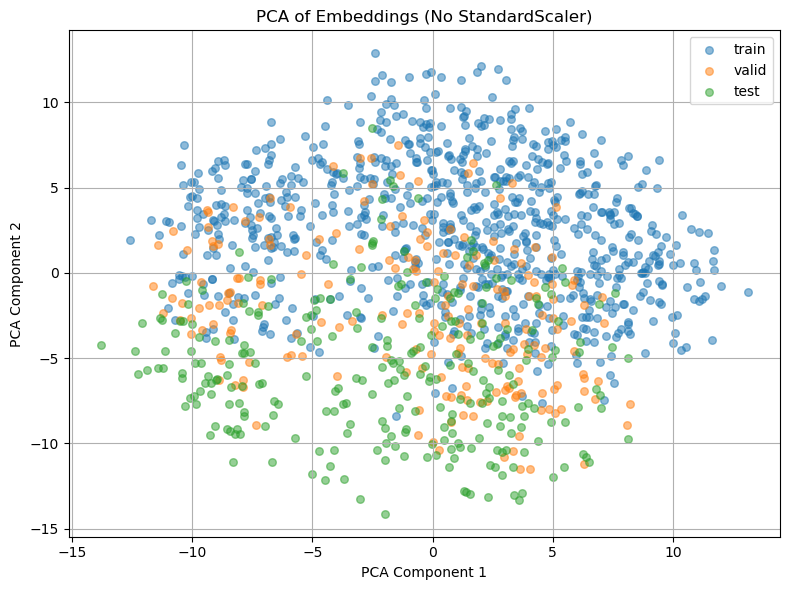

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# 설정
DATA_ROOT   = Path("embbeding_data")
AGG_METHOD  = "max"  # "mean", "max", "flatten" 중 선택

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

# 1. 데이터 불러오기
X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")
X_ts_te, y_te = load_split("test",    "timesformer")
X_st_te, _    = load_split("test",    "stgcnpp")

# 2. ST-GCN 차원 축소
X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

# 3. Concat (TS + ST), 정규화 없이 바로 결합
X_tr = np.concatenate([X_ts_tr, X_st_tr], axis=1)
X_va = np.concatenate([X_ts_va, X_st_va], axis=1)
X_te = np.concatenate([X_ts_te, X_st_te], axis=1)

# 4. PCA 수행
X_comb = np.vstack([X_tr, X_va, X_te])
y_comb = (
    ['train'] * len(X_tr) +
    ['valid'] * len(X_va) +
    ['test']  * len(X_te)
)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_comb)

# 5. 시각화
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, y in enumerate(y_comb) if y == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (No StandardScaler)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# N-fold test 배제 방식


=== Fold 1/10 ===
[Fold 1] ACC: 0.8627, AUC: 0.9122, thr=0.628

=== Fold 2/10 ===
[Fold 2] ACC: 0.8431, AUC: 0.8981, thr=0.657

=== Fold 3/10 ===
[Fold 3] ACC: 0.7255, AUC: 0.8732, thr=0.501

=== Fold 4/10 ===
[Fold 4] ACC: 0.8039, AUC: 0.8984, thr=0.679

=== Fold 5/10 ===
[Fold 5] ACC: 0.7059, AUC: 0.7821, thr=0.527

=== Fold 6/10 ===
[Fold 6] ACC: 0.7451, AUC: 0.9046, thr=0.631

=== Fold 7/10 ===
[Fold 7] ACC: 0.8627, AUC: 0.9613, thr=0.446

=== Fold 8/10 ===
[Fold 8] ACC: 0.7647, AUC: 0.8720, thr=0.456

=== Fold 9/10 ===
[Fold 9] ACC: 0.7200, AUC: 0.8421, thr=0.781

=== Fold 10/10 ===
[Fold 10] ACC: 0.6800, AUC: 0.8474, thr=0.726

🎯 K-Fold 평균 ACC: 0.7714, 평균 AUC: 0.8791


C:\Users\qqppq\AppData\Local\Temp\ipykernel_11292\1683898224.py:153: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\qqppq\AppData\Local\Temp\ipykernel_11292\1683898224.py:153: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\qqppq\AppData\Local\Temp\ipykernel_11292\1683898224.py:153: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\qqppq\AppData\Local\Temp\ipykernel_11292\1683898224.py:154: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.savefig(SAVE_DIR/"kfold_metrics.png")
C:\Users\qqppq\AppData\Local\Temp\ipykernel_11292\1683898224.py:154: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(SAVE_DIR/"kfold_metrics.png")
C:\Users\qqppq\AppData\Local\Temp\ipykernel_11292\1683898224.py:154: 

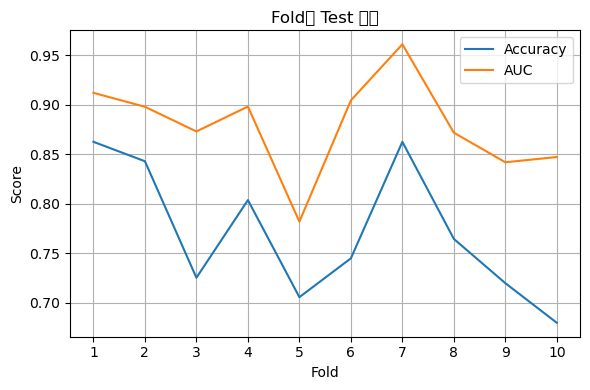

In [12]:
# Jupyter Notebook용: Test 일부로 재학습(fine-tune) 및 이미지 저장까지 포함한 통합 스크립트
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from pathlib import Path

# ───────────────────────────────────────────────────
# 0. 설정
DATA_ROOT       = Path("embbeding_data")
AGG_METHOD      = "max"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 30
EARLY_STOP      = 5
SAVE_DIR        = Path("fusion_images")
SAVE_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────
# 1. 가져오기

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")

X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)

X_train = np.concatenate([X_ts_tr, X_st_tr], axis=1)
X_valid = np.concatenate([X_ts_va, X_st_va], axis=1)
scaler = StandardScaler().fit(np.vstack([X_train, X_valid]))
X_tr_scaled = scaler.transform(X_train).astype(np.float32)
X_va_scaled = scaler.transform(X_valid).astype(np.float32)

X_trva = np.vstack([X_tr_scaled, X_va_scaled])
y_trva = np.concatenate([y_tr, y_va], axis=0)

class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.net(x)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trva, y_trva), start=1):
    print(f"\n=== Fold {fold}/10 ===")
    val_idx = np.array(val_idx)
    val_split = len(val_idx) // 2
    valid_fold_idx = val_idx[:val_split]
    test_fold_idx  = val_idx[val_split:]

    X_train_fold = X_trva[train_idx]
    y_train_fold = y_trva[train_idx]
    X_valid_fold = X_trva[valid_fold_idx]
    y_valid_fold = y_trva[valid_fold_idx]
    X_test_fold  = X_trva[test_fold_idx]
    y_test_fold  = y_trva[test_fold_idx]

    model = HeadMLP(X_train_fold.shape[1]).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit  = nn.CrossEntropyLoss()
    ds_train = TensorDataset(torch.from_numpy(X_train_fold), torch.from_numpy(y_train_fold))
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)

    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS + 1):
        model.train()
        running = 0.0
        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds_train)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        val_tensor = torch.from_numpy(X_valid_fold).to(DEVICE)
        val_out = model(val_tensor)
        val_probs = torch.softmax(val_out, 1)[:, 1].cpu().numpy()

    fpr, tpr, thresholds = roc_curve(y_valid_fold, val_probs)
    opt_thr = thresholds[np.argmax(tpr - fpr)]

    with torch.no_grad():
        test_tensor = torch.from_numpy(X_test_fold).to(DEVICE)
        test_out = model(test_tensor)
        test_probs = torch.softmax(test_out, 1)[:, 1].cpu().numpy()

    test_preds = (test_probs > opt_thr).astype(int)
    acc = accuracy_score(y_test_fold, test_preds)
    auc_score = auc(*roc_curve(y_test_fold, test_probs)[:2])
    cm = confusion_matrix(y_test_fold, test_preds)

    print(f"[Fold {fold}] ACC: {acc:.4f}, AUC: {auc_score:.4f}, thr={opt_thr:.3f}")
    results.append({
        "fold": fold,
        "acc": acc,
        "auc": auc_score,
        "thr": opt_thr,
        "cm": cm,
        "report": classification_report(y_test_fold, test_preds, digits=4, output_dict=True)
    })

avg_acc = np.mean([r['acc'] for r in results])
avg_auc = np.mean([r['auc'] for r in results])
print(f"\n\U0001f3af K-Fold 평균 ACC: {avg_acc:.4f}, 평균 AUC: {avg_auc:.4f}")

plt.figure(figsize=(6,4))
plt.plot([r['fold'] for r in results], [r['acc'] for r in results], label='Accuracy')
plt.plot([r['fold'] for r in results], [r['auc'] for r in results], label='AUC')
plt.title("Fold별 Test 성능")
plt.xlabel("Fold"); plt.ylabel("Score")
plt.xticks(range(1,11)); plt.grid(); plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR/"kfold_metrics.png")
plt.show()
